In [1]:
import cv2
import torch
import unet as Model
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from glob import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class SegData(Dataset):
  def __init__(self, split):
    self.img = glob("dataset1/images_prepped_{}/*.png".format(split), recursive=True)
    self.mask = glob("dataset1/annotations_prepped_{}/*.png".format(split), recursive=True)
  def __len__(self):
    return len(self.img)
  def __getitem__(self, ix):
    img = cv2.imread(self.img[ix], cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask[ix], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (572, 572))
    mask = cv2.resize(mask, (388, 388))
    image = torch.tensor(img).permute(2,0,1).to(device)
    mask = torch.tensor(mask).reshape(388,388).to(device)
    image = image.float() / 255.
    mask = mask.long()
    return image, mask

trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

In [3]:
model = Model.UNet().to(device) #device determines if the model uses cuda(GPU) or not
model.load_state_dict(torch.load('/home/rnakaha2/documents/research/PtychoNeuralNet/UNet/weights/model_0.1056698161865706.pth'))

<All keys matched successfully>

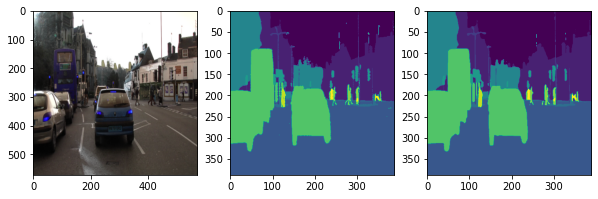

In [50]:
# im, mask = next(iter(val_dl)) # im is original image, mask is correct segmentation
im, mask = next(iter(trn_dl)) # im is original image, mask is correct segmentation
_mask = model(im) # _mask is the models segmentation attempt (prediction)
_mask = torch.argmax(_mask, dim=1).squeeze().cpu().numpy()

f, ax = plt.subplots(1, 3, figsize=(10, 5), facecolor='white')
ax[0].imshow(im.permute(0,2,3,1).detach().cpu()[0])
ax[1].imshow(mask.detach().cpu()[0])
ax[2].imshow(_mask)